In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [23]:
from proj1_helpers import *
test=load_csv_data("../../dataset/test.csv", sub_sample=False)
train=load_csv_data("../../dataset/train.csv", sub_sample=False)

In [79]:
initial_w=np.zeros((30,))
initial_w0=np.zeros((31,))
max_iters=500
gamma=2e-7
lambda_=10
degree=7

In [ ]:
train[1].shape

Need to make a train-test split of train data to cross-validate

In [68]:
from split_data import *
tr_trainX,tr_trainY,tr_testX,tr_testY=split_data(train[1],train[0],0.5)

In [43]:
def build_poly(tx,degree):
    poly = np.ones((len(tx), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(tx, deg)]
    return poly

In [80]:
tx=build_poly(train[1],degree)

In [4]:
from costs import *
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e=y-np.dot(tx,w)
    grad=-tx.T.dot(e)/y.shape[0]
    return grad

def compute_hessian(y, tx, w):
    prev = 1.0 / (1 + np.exp(w.dot(tx)))
    prevv = np.diag(prev.T[0])
    ret = prevv * (1-prevv)
    return tx.T.dot(r).dot(tx)

def least_squares_GD(y,tx,initial_w,max_iters,gamma):
    w = initial_w
    for n_iter in range(max_iters):
        grad=compute_gradient(y,tx,w)
        loss=compute_mse(y,tx,w)
        w=w-gamma*grad
    return w, loss

In [5]:
from helpers import batch_iter
def least_squares_SGD(y,tx,initial_w,max_iters,gamma):
    w = initial_w
    batch_size=50
    for n_iter in range(max_iters):
        for yBatch,txBatch in batch_iter(y, tx, batch_size):
            grad=compute_gradient(yBatch,txBatch,w)
            w=w-gamma*grad
            loss=compute_mse(y,tx,w)
    return w, loss

In [6]:
from costs import *
def least_squares(y,tx):
    if len(y)!=tx.shape[0]:
        raise ValueError("y and tx must have the same length")
    w = np.linalg.solve(np.dot(tx.transpose(), tx), np.dot(tx.transpose(), y))
    loss=compute_mse(y,tx,w)
    return w, loss

In [7]:
from costs import *
def ridge_regression(y,tx,lambda_):
    w=np.linalg.solve(tx.T.dot(tx)+2*tx.shape[0]*lambda_*np.eye(tx.shape[1]),tx.T.dot(y))
    loss=compute_mse(y,tx,w)
    return w, loss

In [ ]:
def logistic_regression(y,tx,initial_w,max_iters,gamma):
    hess = compute_hessian(y, tx, w)
    
    return w, loss

In [ ]:
def reg_logistic_regression(y,tx,lambda_,initial_w,max_iters,gamma):
    return w, loss

In [21]:
def nullspace_projection(y,tx,vector):
    txp=np.linalg.pinv(tx)
    N=np.eye(tx.shape[1])-txp.dot(tx)
    w=txp.dot(y)+N.dot(vector)
    loss=compute_mse(y,tx,w)
    return w, loss

In [14]:
w,loss=least_squares_GD(train[0],train[1],initial_w,max_iters,gamma)
print(loss)

0.389005293611


In [15]:
w,loss=least_squares_SGD(train[0],train[1],initial_w,max_iters,gamma)
print(loss)

0.390987983542


In [ ]:
w,loss=least_squares(train[0],tx)
print(loss)

In [72]:
degree=3
tx=build_poly(tr_trainX,degree)
w,loss=least_squares(tr_trainY,tx)
tx_trtest=build_poly(tr_testX,degree)
print(loss)
print(compute_mse(tr_testY,tx_trtest,w))

0.310691493163
24.8298898256


0.291914863611
0.314893882941


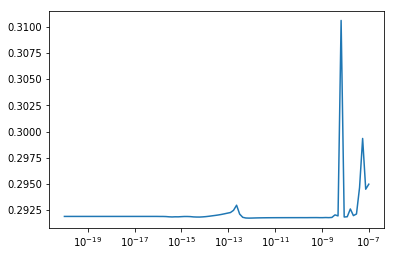

In [63]:
lambdas= np.logspace(-20, -7, 100)
losses=[]
for lambda_ in lambdas:
    w,loss=ridge_regression(train[0],tx,lambda_)
    losses.append(loss)
plt.semilogx(lambdas,losses)

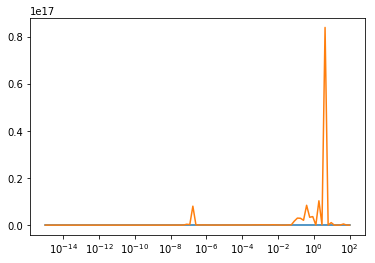

In [83]:
degree=7
tx=build_poly(tr_trainX,degree)
tx_trtest=build_poly(tr_testX,degree)
lambdas= np.logspace(-15, 2, 100)
losses=[]
losses_te=[]
for lambda_ in lambdas:
    w,loss=ridge_regression(tr_trainY,tx,lambda_)
    losses.append(loss)
    losses_te.append(compute_mse(tr_testY,tx_trtest,w))
plt.semilogx(lambdas,losses)
plt.semilogx(lambdas,losses_te)

In [81]:
w,loss=ridge_regression(train[0],tx,lambda_)
print(loss)

0.328819421663


In [57]:
degree=7
V=np.zeros((train[1].shape[1]*degree+1,))
V[0]=1
V[-1]=1
w,loss=nullspace_projection(train[0],tx,V)
print(loss)

5.28711379641e+22


In [82]:
tx_test=build_poly(test[1],degree)
ypred=predict_labels(w,tx_test)
create_csv_submission(test[2],ypred,"submission.csv")